# CNN model for predicting Sex from ECGs

In [1]:
import tensorflow as tf # Make sure that python interpreter is 3.9.13 Global env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU')


[]

### Loading raw data into mutable Datframes

In [ ]:
ptb = pd.read_csv('../data/ptbxl_database.csv')

In [3]:

def load_raw_data(df, sampling_rate, path):
    if(sampling_rate == 100):
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data



In [5]:
sampling_rate=100
# load and convert annotation data
Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))



In [6]:
# Load raw signal data
X = load_raw_data(Y, 100, '../data/')

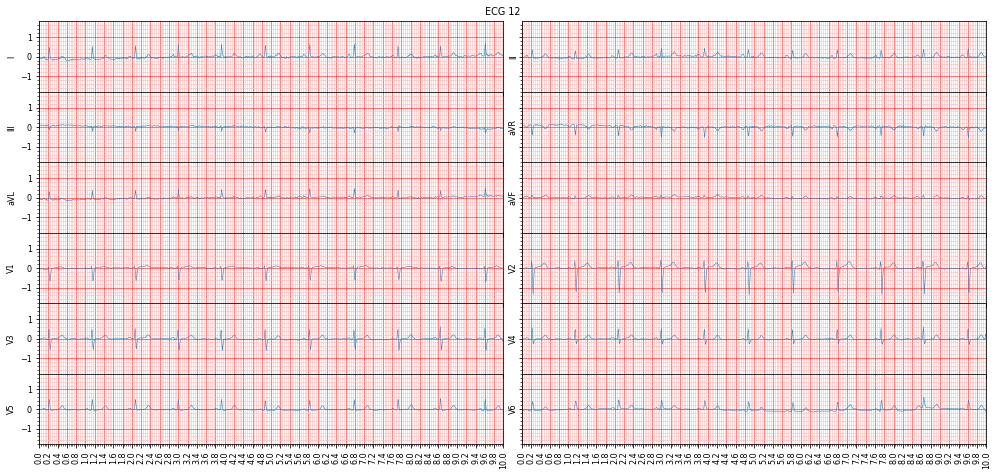

In [7]:
ecg_plot.plot_12(tf.transpose(X, (0,2,1))[0], sample_rate=100)

In [8]:

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

agg_df.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
LAFB,left anterior fascicular block,1.0,NaN,NaN,CD,LAFB/LPFB,Intraventricular and intra-atrial Conduction d...,left anterior fascicular block,101.0,MDC_ECG_BEAT_BLK_ANT_L_HEMI,C62267,D3-33140
ISC_,non-specific ischemic,1.0,NaN,NaN,STTC,ISC_,Basic roots for coding ST-T changes and abnorm...,ischemic ST-T changes,226.0,NaN,NaN,NaN


In [41]:
Y_pd = pd.DataFrame(Y)
Y_pd.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


### Visualizing the Data

Text(0.5, 1.0, 'Distribution of Sex')

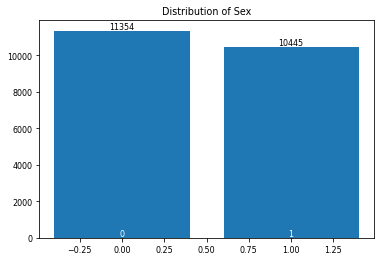

In [10]:
# Distribution of Male and Female ECGs
uniques, counts = np.unique(Y_pd.sex, return_counts=True)
plt.bar(uniques, counts)
for i in range(len(uniques)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    plt.text(i, i, str(i), ha='center', va='bottom', color = "white")
plt.title("Distribution of Sex")

Text(0.5, 1.0, 'Distribution of Diagnostic Superclasses')

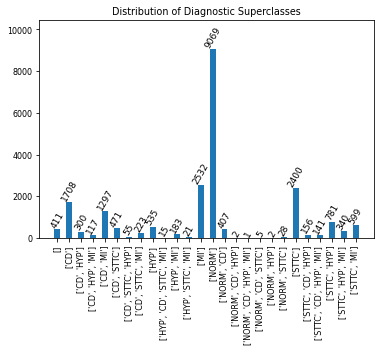

In [11]:
diag_uniques, diag_counts = np.unique(Y_pd.diagnostic_superclass, return_counts=True)
temp = [str(i) for i in diag_uniques]
plt.bar(temp, diag_counts, width = 0.5)
for i in range(len(diag_uniques)):
    plt.text(i, diag_counts[i], str(diag_counts[i]), ha='center', va='bottom', size = 9, rotation = 60)

plt.xticks(rotation = 90)
plt.ylim(0, max(diag_counts) + max(diag_counts)*0.15)
plt.title("Distribution of Diagnostic Superclasses")

* NORM: Normal ECG
* MI: Myocardial Infarction
* STTC: ST/T Change
* CD: Conduction Disturbance
* HYP: Hypertrophy


To accurately predict the diagnostic superclass, much more data cleaning is required. 
* I will either need to trim the superclass list or spread out the concatenated data and one hot encode it. 

## Data Augmentation

### Normalization

In [12]:
def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X, axis=(-1), keepdims=True)
    X_std = np.std(X, axis=(-1), keepdims= True)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

(21799, 1000, 1)

### Baseline Drift Augmentation

In [13]:
import random
# Defining constant BL drift
bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape[0])
    return X + np.expand_dims(random_shifts, axis=(1, 2))

(21799, 1000, 12)

### DA Applyer

In [14]:
def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

func_dict = [{'func': normalize, 'params': [None]}, 
             {'func': baseline_drift, 'params': [0.5,1]}]

X_final = da_apply(X, func_dict)


array([[[-0.59844998,  0.78021416,  0.73906   , ...,  1.33579523,
          0.21434455,  0.26578724],
        [-0.80632554,  0.79066873,  1.02552083, ...,  1.26037293,
          0.09785504,  0.16831067],
        [-1.06792948,  0.80903748,  1.49510127, ...,  1.00320648,
         -0.2135859 , -0.0970845 ],
        ...,
        [ 0.77931775,  1.18199958,  1.00609885, ..., -0.94480011,
         -0.11181568,  0.37663592],
        [-0.66311156,  0.72851435,  1.91303144, ..., -0.49597111,
         -0.11445487,  0.26342788],
        [-1.31195248,  0.13640338,  1.86252611, ..., -1.11354757,
         -0.73161811, -0.30504755]],

       [[ 0.37754233, -0.67606418, -0.04390027, ..., -1.1817953 ,
         -0.61284779, -0.40212648],
        [ 0.22181153, -0.52347522,  0.22181153, ..., -1.24746807,
         -0.71512038, -0.4808874 ],
        [-0.40078602, -0.47186138,  0.80749499, ..., -0.96938885,
         -0.68508744, -0.40078602],
        ...,
        [-0.15146323, -1.56114464, -1.36078383, ...,  

### Splitting Data into Train, validation, testing

In [15]:

# Split data into train and test
test_fold =10
val_fold = 9

def tvt_split(X, Y, val_fold, test_fold, shape = False):
    X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
    y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

    X_val = X[Y.strat_fold == val_fold]
    y_val = Y[Y.strat_fold == val_fold].age

    X_test = X[(Y.strat_fold == test_fold)]
    y_test = Y[Y.strat_fold == test_fold].age

    y_train = pd.get_dummies(y_train)
    y_val = pd.get_dummies(y_val)
    y_test = pd.get_dummies(y_test)

    y_train = y_train.idxmax(axis = 1).to_numpy()
    y_val = y_val.idxmax(axis = 1).to_numpy()
    y_test = y_test.idxmax(axis = 1).to_numpy()

    if(shape == True):
        print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((19601, 1000, 12), (2198, 1000, 12), (19601,), (2198,))

In [16]:
type(X_train)

numpy.ndarray

# Evaluating data distribution

Text(0.5, 1.0, 'Distribution of Sex')

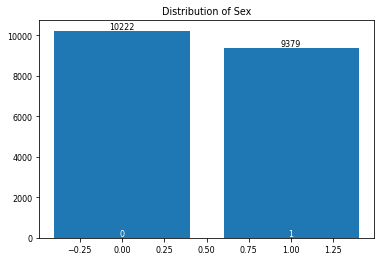

In [17]:
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)
plt.bar(uniques, counts)
for i in range(len(uniques)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    plt.text(i, i, str(i), ha='center', va='bottom', color = "white")
plt.title("Distribution of Sex")

In [18]:
# # Reshaping for ecg_sex_ecg_sex_ecg_sex_ecg_sex_ecg_sex_ecg_sex_model_8_8_8_8_8_8
# X_train = tf.reshape(X_train, (19601, 1000, 12,1))
# X_test = tf.reshape(X_test, (2198, 1000, 12,1))

# Model Creation

### Model 1
* Few Hidden layers
* Deafault 0.001 learning rate
* 2 layers of spatial analysis
* 1 Fully connected layer
* Relu and Sigmoid activations

In [19]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 10, kernel_size = 7, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 25, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history = ecg_sex_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
613/613 [==============================] - 13s 16ms/step - loss: 0.7007 - accuracy: 0.5220 - val_loss: 0.6927 - val_accuracy: 0.5150
Epoch 2/10
613/613 [==============================] - 8s 14ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6927 - val_accuracy: 0.5150
Epoch 3/10
613/613 [==============================] - 9s 14ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 4/10
613/613 [==============================] - 9s 15ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 5/10
613/613 [==============================] - 9s 14ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 6/10
613/613 [==============================] - 9s 15ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.5150
Epoch 7/10
613/613 [==============================] - 10s 16ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6928 - val_accuracy: 0.51

### Model 2
* Modification of the number of neurons. 
* Adjusted learning rate slighlty

In [20]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 3, padding = "valid", activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0015),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history_2 = ecg_sex_model_2.fit(X_train, y_train, epochs = 8, validation_data = (X_test, y_test))

Epoch 1/8
613/613 [==============================] - 10s 14ms/step - loss: 0.5733 - accuracy: 0.7020 - val_loss: 0.5994 - val_accuracy: 0.6733
Epoch 2/8
613/613 [==============================] - 11s 17ms/step - loss: 0.4836 - accuracy: 0.7725 - val_loss: 0.5131 - val_accuracy: 0.7457
Epoch 3/8
613/613 [==============================] - 10s 17ms/step - loss: 0.4343 - accuracy: 0.7988 - val_loss: 0.5006 - val_accuracy: 0.7666
Epoch 4/8
613/613 [==============================] - 9s 15ms/step - loss: 0.3895 - accuracy: 0.8225 - val_loss: 0.5261 - val_accuracy: 0.7470
Epoch 5/8
613/613 [==============================] - 10s 17ms/step - loss: 0.3323 - accuracy: 0.8482 - val_loss: 0.5911 - val_accuracy: 0.6893
Epoch 6/8
613/613 [==============================] - 19s 31ms/step - loss: 0.2695 - accuracy: 0.8766 - val_loss: 0.7079 - val_accuracy: 0.7416
Epoch 7/8
613/613 [==============================] - 22s 36ms/step - loss: 0.2141 - accuracy: 0.9012 - val_loss: 0.7222 - val_accuracy: 0.7343


### Model 3
* Additional spatial layer


**Key Issues at this time**
* The model appeared to be over fitting to the training data evidenced by the varying accuracies between training and testing

In [ ]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Conv1D(filters = 96, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dense(25, activation= 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_3.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0015),
                      metrics = ['accuracy'])

# Learning rate scheduler




# Fitting the model

history_3 = ecg_sex_model_3.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))

### Model 4
* Implemented learning rate scheduler callback
* Implemented early stop callback
* Additional spatial layer
* Weaved in batch normalization
* Implemented weight droppout

In [ ]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_4.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)



# Fitting the model

history_4 = ecg_sex_model_4.fit(X_train, y_train, epochs = 12, validation_data = (X_test, y_test), callbacks = early_stopper)

Epoch 1/12
613/613 [==============================] - 16s 23ms/step - loss: 0.5491 - accuracy: 0.7358 - val_loss: 0.5383 - val_accuracy: 0.7416
Epoch 2/12
613/613 [==============================] - 13s 22ms/step - loss: 0.4522 - accuracy: 0.7949 - val_loss: 0.4756 - val_accuracy: 0.7762
Epoch 3/12
613/613 [==============================] - 14s 23ms/step - loss: 0.4271 - accuracy: 0.8080 - val_loss: 0.5254 - val_accuracy: 0.7630
Epoch 4/12
613/613 [==============================] - 13s 21ms/step - loss: 0.4096 - accuracy: 0.8166 - val_loss: 0.4968 - val_accuracy: 0.7662
Epoch 5/12
613/613 [==============================] - 13s 22ms/step - loss: 0.3976 - accuracy: 0.8247 - val_loss: 0.4502 - val_accuracy: 0.7880
Epoch 6/12
613/613 [==============================] - 13s 22ms/step - loss: 0.3868 - accuracy: 0.8312 - val_loss: 0.4738 - val_accuracy: 0.7925
Epoch 7/12
613/613 [==============================] - 13s 22ms/step - loss: 0.3724 - accuracy: 0.8355 - val_loss: 0.4704 - val_accuracy:

### Model 5
* 5 spatial layers each with their own batch normalization
* Modified learning rate
* Implemented Lasso L1 regularizer. 
* Early stopper in place

In [ ]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)
tf.keras.backend.set_image_data_format('channels_first')


# Creating the model

ecg_sex_model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu', input_shape= (1000, 12)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_5.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_5 = ecg_sex_model_5.fit(X_train, y_train, epochs = 12, validation_data = (X_test, y_test), callbacks = (early_stopper))

### Model 6
* Wanted to see if model's performance was proportional to training time
* Doubled the epochs and disabled the early stopper


**Take aways**
* The model's training accuracy consistently grew with epochs
* The model's testing accuracy fluctuated and plateaued around 0.8
* The number of epochs has little effect on testing accuracy when the model overfits.

In [33]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model

ecg_sex_model_6 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 160, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_6.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_6 = ecg_sex_model_6.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20
613/613 [==============================] - 21s 30ms/step - loss: 3.3684 - accuracy: 0.7332 - val_loss: 1.2141 - val_accuracy: 0.7680
Epoch 2/20
613/613 [==============================] - 19s 31ms/step - loss: 1.1280 - accuracy: 0.7886 - val_loss: 1.2369 - val_accuracy: 0.7489
Epoch 3/20
613/613 [==============================] - 19s 31ms/step - loss: 1.0520 - accuracy: 0.7994 - val_loss: 1.1280 - val_accuracy: 0.7525
Epoch 4/20
613/613 [==============================] - 19s 31ms/step - loss: 0.9651 - accuracy: 0.8081 - val_loss: 0.9342 - val_accuracy: 0.7734
Epoch 5/20
613/613 [==============================] - 19s 31ms/step - loss: 0.9707 - accuracy: 0.8132 - val_loss: 1.0522 - val_accuracy: 0.7921
Epoch 6/20
613/613 [==============================] - 19s 31ms/step - loss: 0.9497 - accuracy: 0.8219 - val_loss: 1.0735 - val_accuracy: 0.7671
Epoch 7/20
613/613 [==============================] - 19s 31ms/step - loss: 0.9314 - accuracy: 0.8248 - val_loss: 0.9624 - val_accuracy:

(19601, 1000, 12)

### Model 7
* 8 spatial layers
* 1 temporal layer
* 2 Fully connected layer
* https://www.ahajournals.org/doi/full/10.1161/CIRCEP.119.007284

In [42]:
tf.debugging.disable_traceback_filtering
tf.config.list_physical_devices('GPU')
# Random Seed

# Creating the model

ecg_sex_model_7 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model

ecg_sex_model_7.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= .003),
                      metrics = ['accuracy'])

# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model

history_7 = ecg_sex_model_7.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test))

KeyboardInterrupt: 

In [34]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize = (10, 10)

def make_confusion_matrix(X_test, y_test, classes, model, figsize=(18,18), text_size = 15):
    # Create the confusion matrix
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    cm = confusion_matrix(y_test, tf.round(y_pred))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=(str(model.name) + " for Confusion Matrix"),
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=10)

### Visualization of data

69/69 [==============================] - 0s 5ms/step


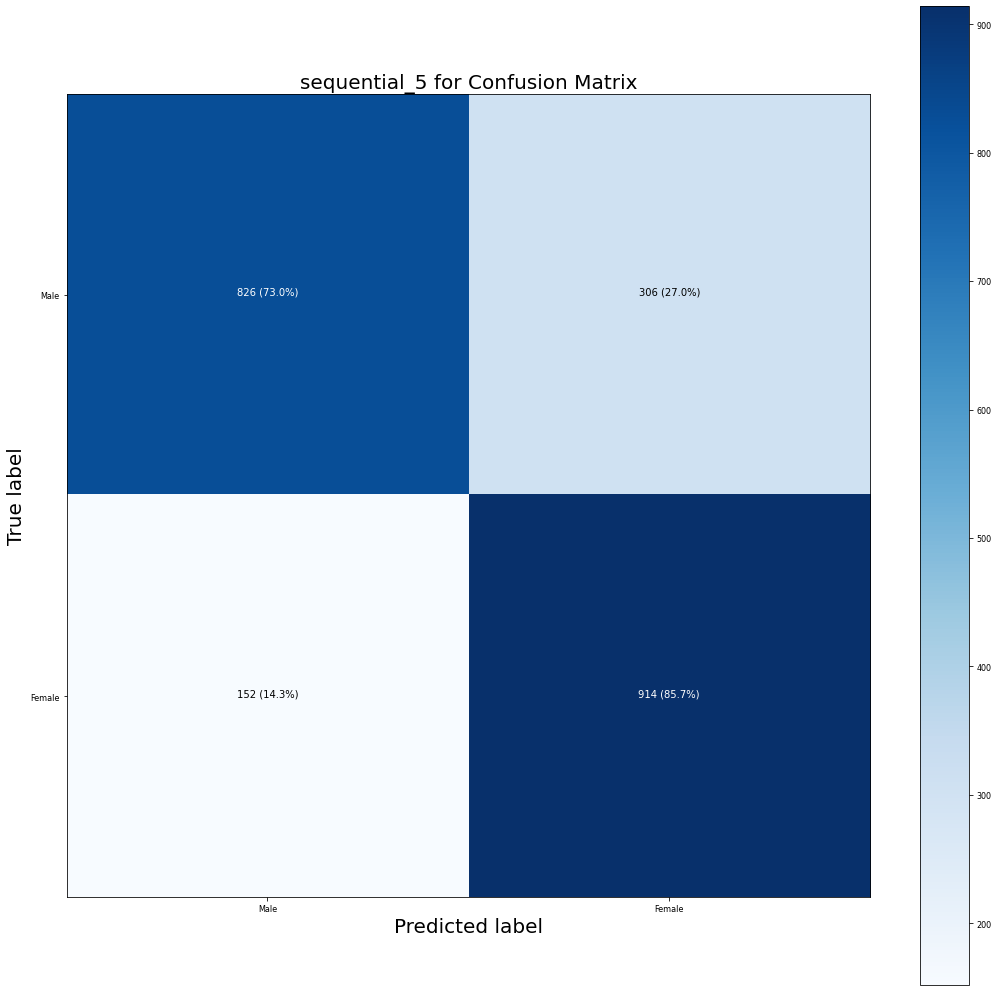

In [35]:
y_prob = ecg_sex_model_6.predict(X_test)
y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))


class_name = ['Male', 'Female']
make_confusion_matrix(X_test, y_test, model = ecg_sex_model_6, classes = class_name)



# Visualizing the ECGs with model interpretation
* External resources:
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2760216/

69/69 [==============================] - 1s 7ms/step


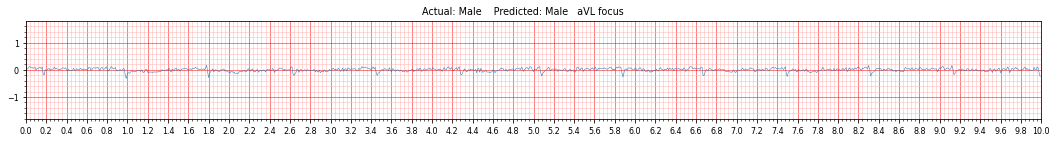

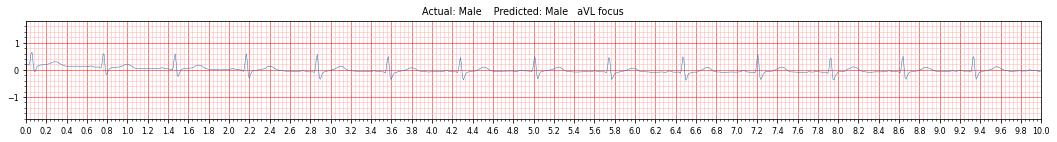

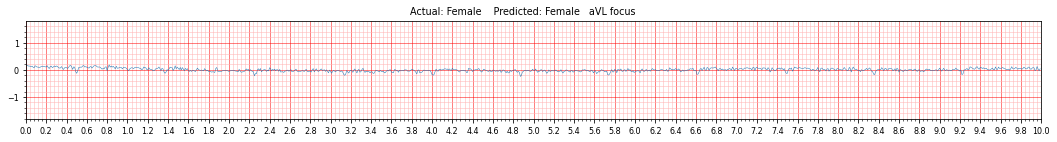

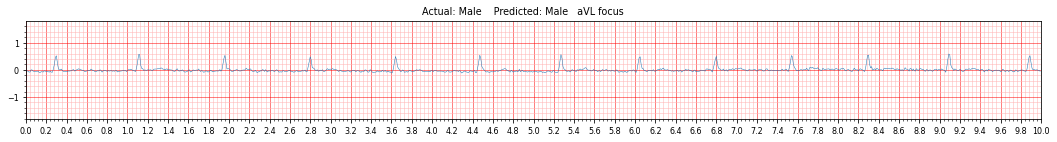

In [38]:
from random import choice

def visualize(y_test, X_test, model):
    class_names  = ['Male', 'Female']
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    for i in range(4):
        ind = choice(range(1, len(X_test)))
        plot_title = ("Actual: " + class_names[y_test[ind]] + "    Predicted: " + class_names[y_pred[ind]])
        ecg_plot.plot_1(tf.transpose(X, (0,2,1))[ind][4], sample_rate=100, title = plot_title + "   aVL focus")

visualize(y_test, X_test, ecg_sex_model_6)

69/69 [==============================] - 1s 7ms/step


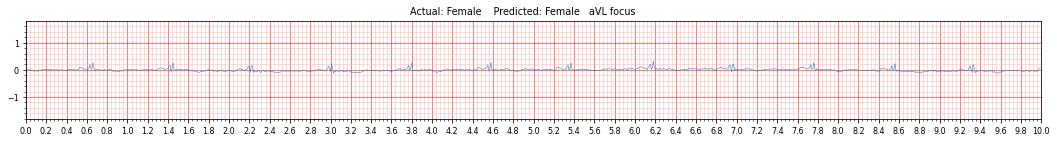

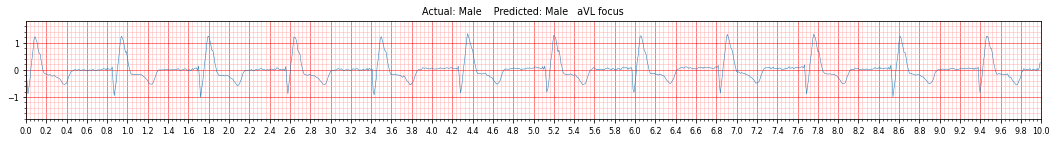

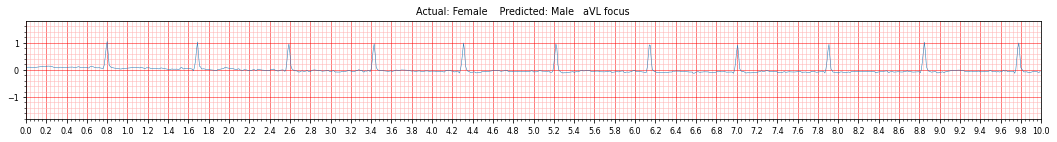

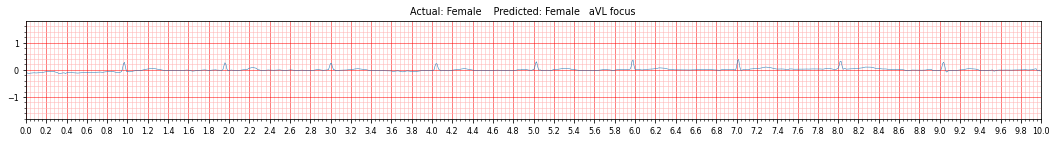

In [46]:
from random import choice

def visualize(y_test, X_test, model):
    class_names  = ['Male', 'Female']
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    for i in range(4):
        ind = choice(range(1, len(X_test)))
        plot_title = ("Actual: " + class_names[y_test[ind]] + "    Predicted: " + class_names[y_pred[ind]])
        ecg_plot.plot_1(tf.transpose(X, (0,2,1))[ind][4], sample_rate=100, title = plot_title + "   aVL focus")

visualize(y_test, X_test, ecg_sex_model_6)


### Conclusions
* Attempt to train on the 500hz data set
* Use a cloud computing system to train larger models such as Google Collab. 
* Fine tune an existing high performance model such as ResNet. 